In [ ]:
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras

import numpy as np
from numpy import load
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Load Dataset

In [ ]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [ ]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [ ]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

In [ ]:
n_steps = 60
series = load('univariate-time-series-multi-step.npy')

X_train, y_train = series[:9000, :n_steps], series[:9000, -1] # -1 references the last column
X_valid, y_valid = series[9000:11000, :n_steps], series[9000:11000, -1]
X_test, y_test = series[11000:, :n_steps], series[11000:, -1]

## Improving multi-step prediction model

Instead of training the model to forecast the next 10 values only at the very last time step, we can train it to forecast the next 10 values at each and every time step. In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN. The advantage of this technique is that the loss will contain a term for the output of the RNN at each and every time step, not just the output at the last time step. This means there will be many more error gradients flowing through the model, and they will also flow from the output of each time step. This will both stabilize and speed up training. To be clear, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 10, then at time step 1 the model will forecast time steps 2 to 11, and so on. So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences.

In [ ]:
Y = np.empty((12000, n_steps, 10)) 

In [ ]:
# each target is a sequence of 10D vectors, because in each of the 60 time steps the model will predict 10 time steps
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
    # same as     Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
    # broadcasting 1-61 to 0th element of z axis of each of the 10k rows
    # then 2-62 to 1st element of z-axis ... all the way till 10-70 to 9th element of z axis of the 10k rows 
Y_train = Y[:9000]
Y_valid = Y[9000:11000]
Y_test = Y[11000:]

In [ ]:
X_train.shape, Y_train.shape

((9000, 60, 1), (9000, 60, 10))

In [ ]:
model = keras.models.Sequential([
    keras.layers.LSTM(60, return_sequences=True),          
    keras.layers.LSTM(60, return_sequences=True),               
    keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'sigmoid')),
    keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/20
282/282 [==============================] - 26s 76ms/step - loss: 0.0598 - last_time_step_mse: 0.0542 - val_loss: 0.0318 - val_last_time_step_mse: 0.0252
Epoch 2/20
282/282 [==============================] - 20s 72ms/step - loss: 0.0286 - last_time_step_mse: 0.0183 - val_loss: 0.0245 - val_last_time_step_mse: 0.0130
Epoch 3/20
282/282 [==============================] - 21s 73ms/step - loss: 0.0244 - last_time_step_mse: 0.0135 - val_loss: 0.0209 - val_last_time_step_mse: 0.0084
Epoch 4/20
282/282 [==============================] - 20s 72ms/step - loss: 0.0224 - last_time_step_mse: 0.0117 - val_loss: 0.0208 - val_last_time_step_mse: 0.0102
Epoch 5/20
282/282 [==============================] - 21s 74ms/step - loss: 0.0211 - last_time_step_mse: 0.0105 - val_loss: 0.0197 - val_last_time_step_mse: 0.0080
Epoch 6/20
282/282 [==============================] - 21s 74ms/step - loss: 0.0205 - last_time_step_mse: 0.0099 - val_loss: 0.0183 - val_last_time_step_mse: 0.0085
Epoch 7/20
282/2

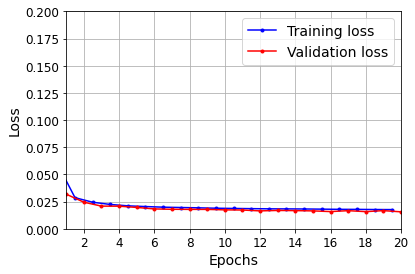

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
series = load('univariate-time-series-multi-step-test.npy')
X_new, Y_new = series[:, :60, :], series[:, 60:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

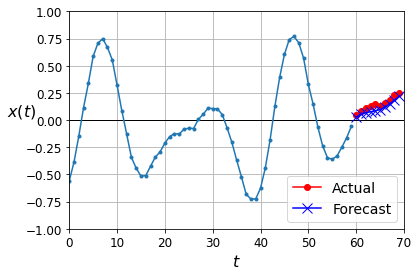

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [ ]:
model.evaluate(X_test, Y_test)
#outputs [loss (mse), last_time_step_mse]

# keras.layers.TimeDistributed(keras.layers.Flatten(input_shape=[60, 1])),
# keras.layers.TimeDistributed(keras.layers.Dense(10))
# 32/32 [==============================] - 0s 1ms/step - loss: 0.0960 - last_time_step_mse: 0.0996
# [0.09603306651115417, 0.09957660734653473]


    # keras.layers.TimeDistributed(keras.layers.Flatten(input_shape=[60, 1])),
    # keras.layers.TimeDistributed(keras.layers.Dense(60)),
    # keras.layers.TimeDistributed(keras.layers.Dense(10))
#     32/32 [==============================] - 0s 1ms/step - loss: 0.0961 - last_time_step_mse: 0.0985
# [0.09605885297060013, 0.0985264927148819]


#     keras.layers.LSTM(60, return_sequences=True),                        
#     keras.layers.TimeDistributed(keras.layers.Dense(60)),
#     keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
#     32/32 [==============================] - 0s 11ms/step - loss: 0.0168 - last_time_step_mse: 0.0056
# [0.016800176352262497, 0.005558297038078308]


    # keras.layers.LSTM(60, return_sequences=True),          
    # keras.layers.LSTM(60, return_sequences=True),              
    # keras.layers.TimeDistributed(keras.layers.Dense(60)),
    # keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
    # keras.layers.TimeDistributed(keras.layers.Dense(10))
# 32/32 [==============================] - 1s 19ms/step - loss: 0.0158 - last_time_step_mse: 0.0050
# [0.01580606959760189, 0.004992151632905006]


# 32/32 [==============================] - 1s 31ms/step - loss: 7.3610e-04 - last_time_step_mse: 0.0077
# [0.000736100017093122, 0.007664072327315807]



#     keras.layers.LSTM(60, return_sequences=True),          
#     keras.layers.LSTM(60, return_sequences=True),               
#     keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'sigmoid')),
#     keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
#     32/32 [==============================] - 1s 19ms/step - loss: 0.0156 - last_time_step_mse: 0.0048
# [0.015639493241906166, 0.00479859346523881]


    # keras.layers.LSTM(60, return_sequences=True),          
    # keras.layers.LSTM(60, return_sequences=True),               
    # keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'relu')),
    # keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
    # keras.layers.TimeDistributed(keras.layers.Dense(10))
    #     32/32 [==============================] - 1s 19ms/step - loss: 0.0156 - last_time_step_mse: 0.0052
# [0.015639493241906166, 0.00479859346523881]

    # keras.layers.LSTM(30, return_sequences=True),          
    # keras.layers.LSTM(60, return_sequences=True),               
    # keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'sigmoid')),
    # keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
    # keras.layers.TimeDistributed(keras.layers.Dense(10))
# 32/32 [==============================] - 1s 16ms/step - loss: 0.0160 - last_time_step_mse: 0.0055
# [0.015988852828741074, 0.005487416870892048]

#     keras.layers.LSTM(60, return_sequences=True),          
#     keras.layers.LSTM(120, return_sequences=True),               
#     keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'sigmoid')),
#     keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
#     keras.layers.TimeDistributed(keras.layers.Dense(10))
#     32/32 [==============================] - 1s 29ms/step - loss: 0.0156 - last_time_step_mse: 0.0048
#     [0.015556414611637592, 0.0048195417039096355]

32/32 [==============================] - 1s 19ms/step - loss: 0.0156 - last_time_step_mse: 0.0048


[0.015639493241906166, 0.00479859346523881]